# Livneh Average Tmax Over California and Nevada

In [1]:
# imports
import numpy
import Nio
import Ngl
from IPython import display
import netCDF4 as nc
from datetime import date
from datetime import timedelta
import xarray as xr
import xesmf as xe

In [2]:
# reading in livneh
fn = '/cw3e/mead/projects/cwp103/scratch/ldehaan/Livneh/ptt_2017.nc'
liv = xr.open_dataset(fn)
liv['Tmax'][35:46]

<xarray.DataArray 'Tmax' (Time: 11, lat: 444, lon: 922)>
[4503048 values with dtype=float32]
Coordinates:
  * Time     (Time) datetime64[ns] 2017-02-05 2017-02-06 ... 2017-02-15
  * lat      (lat) float64 25.16 25.22 25.28 25.34 ... 52.66 52.72 52.78 52.84
  * lon      (lon) float64 -124.6 -124.5 -124.5 -124.4 ... -67.16 -67.09 -67.03
Attributes:
    units:    Celsius

In [3]:
# averaging
sum_arr = liv['Tmin'][35].data
for i in numpy.arange(36, 46):
    sum_arr += liv['Tmin'][i].data
avg = sum_arr / 11

# for reference
numpy.unique(avg), numpy.unique(sum_arr)

(array([-28.717756, -28.285383, -28.135376, ...,        nan,        nan,
               nan], dtype=float32),
 array([-315.89532, -311.13922, -309.48914, ...,        nan,        nan,
               nan], dtype=float32))

In [4]:
# convert dif_arr to masked array to overlook NaNs
import numpy.ma as ma
m_out = ma.masked_invalid(avg)
m_out

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

In [5]:
# create dataarray structure
lat_coord = liv['lat'].data.flatten()
lon_coord = liv['lon'].data.flatten()
d_arr = xr.DataArray(m_out, coords = [lat_coord, lon_coord], dims = ['lat', 'lon'])
d_arr

<xarray.DataArray (lat: 444, lon: 922)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 25.16 25.22 25.28 25.34 ... 52.66 52.72 52.78 52.84
  * lon      (lon) float64 -124.6 -124.5 -124.5 -124.4 ... -67.16 -67.09 -67.03

In [6]:
# extract CA/NV chunk (n < 43 lat, n > 31 lat, n > -113 lon)
lat_drop = d_arr.where(d_arr.lat < 42, drop = True)
lat_drop = lat_drop.where(lat_drop.lat > 31, drop = True)
lon_drop = lat_drop.where(lat_drop.lon < -114, drop = True)
lon_drop

<xarray.DataArray (lat: 176, lon: 170)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., -3.6177447, -4.007686 ,
        -5.472267 ],
       [       nan,        nan,        nan, ..., -3.6440375, -3.259965 ,
        -3.646328 ],
       [       nan,        nan,        nan, ..., -4.391641 , -3.3798704,
        -2.9719481]], dtype=float32)
Coordinates:
  * lat      (lat) float64 31.03 31.09 31.16 31.22 ... 41.78 41.84 41.91 41.97
  * lon      (lon) float64 -124.6 -124.5 -124.5 -124.4 ... -114.2 -114.1 -114.0

In [7]:
# convert to masked array to overlook NaNs
m_out = ma.masked_invalid(lon_drop)
m_out

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., -3.6177446842193604, -4.007686138153076,
         -5.472267150878906],
        [--, --, --, ..., -3.6440374851226807, -3.259964942932129,
         -3.6463279724121094],
        [--, --, --, ..., -4.391641139984131, -3.3798704147338867,
         -2.9719481468200684]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)

In [8]:
# numerical data, average across CA/NV region
numpy.mean(m_out)

2.1086640761676296

In [9]:
wks_type2 = "png"
wks2 = Ngl.open_wks(wks_type2,"17_livneh_avg_ca_nv_tmin")

In [10]:
# defining variables
temp = m_out
tmax_lon  =  lon_drop['lon'].data.flatten()
tmax_lat  =  lon_drop['lat'].data.flatten()
tmax_nlon =  len(tmax_lon)
tmax_nlat =  len(tmax_lat)

In [11]:
# XY of overlay plot
resources = Ngl.Resources()
resources.sfXCStartV = min(tmax_lon)
resources.sfXCEndV   = max(tmax_lon)
resources.sfYCStartV = min(tmax_lat)
resources.sfYCEndV   = max(tmax_lat)

# fill missing values as needed
if hasattr(temp,"_FillValue"):
    resources.sfMissingValueV = temp._FillValue

# plot styling
cmap = ['Ghostwhite', 'Grey0', 
        'Purple4', 'RoyalBlue3', 'RoyalBlue1', 'DeepSkyBlue', 'Cyan', 'DarkTurquoise', 
        'SeaGreen2', 'SpringGreen', 'Green', 'GreenYellow', 'OliveDrab2', 'Yellow', 
        'Gold', 'Orange', 'DarkOrange', 'Red', 'Red']
resources.wkColorMap = cmap
Ngl.set_values(wks2,resources)
resources.cnLevelSelectionMode = "ManualLevels"
resources.cnMinLevelValF       = -20
resources.cnMaxLevelValF       = 32
resources.cnLevelSpacingF      = 4
resources.tiXAxisString = "~F25~Longitude"
resources.tiYAxisString = "~F25~Latitude"
resources.cnFillOn              = True    
resources.cnLineLabelsOn        = False  
resources.cnInfoLabelOn         = False  
resources.nglSpreadColorEnd     = -2
resources.mpProjection = "LambertEqualArea" 
resources.mpCenterLonF = (tmax_lon[tmax_nlon-1] + tmax_lon[0])/2
resources.mpCenterLatF = (tmax_lat[tmax_nlat-1] + tmax_lat[0])/2
resources.mpLimitMode = "LatLon"
resources.mpMinLonF   = min(tmax_lon)
resources.mpMaxLonF   = max(tmax_lon)
resources.mpMinLatF   = min(tmax_lat)
resources.mpMaxLatF   = max(tmax_lat)
resources.mpPerimOn   = True
resources.cnLinesOn   = False
resources.mpOutlineBoundarySets = "GeophysicalAndUSStates"
resources.pmTickMarkDisplayMode = "Never"
resources.tiMainString = "~F26~Livneh Tmin Average, CA/NV, 2017-02"
resources.lbOrientation  = "Horizontal"
resources.lbTitleString  = "~F25~Max Temp (C)"

In [12]:
# plot
map = Ngl.contour_map(wks2,temp,resources)

In [13]:
# clean up
del map
del resources
Ngl.end()

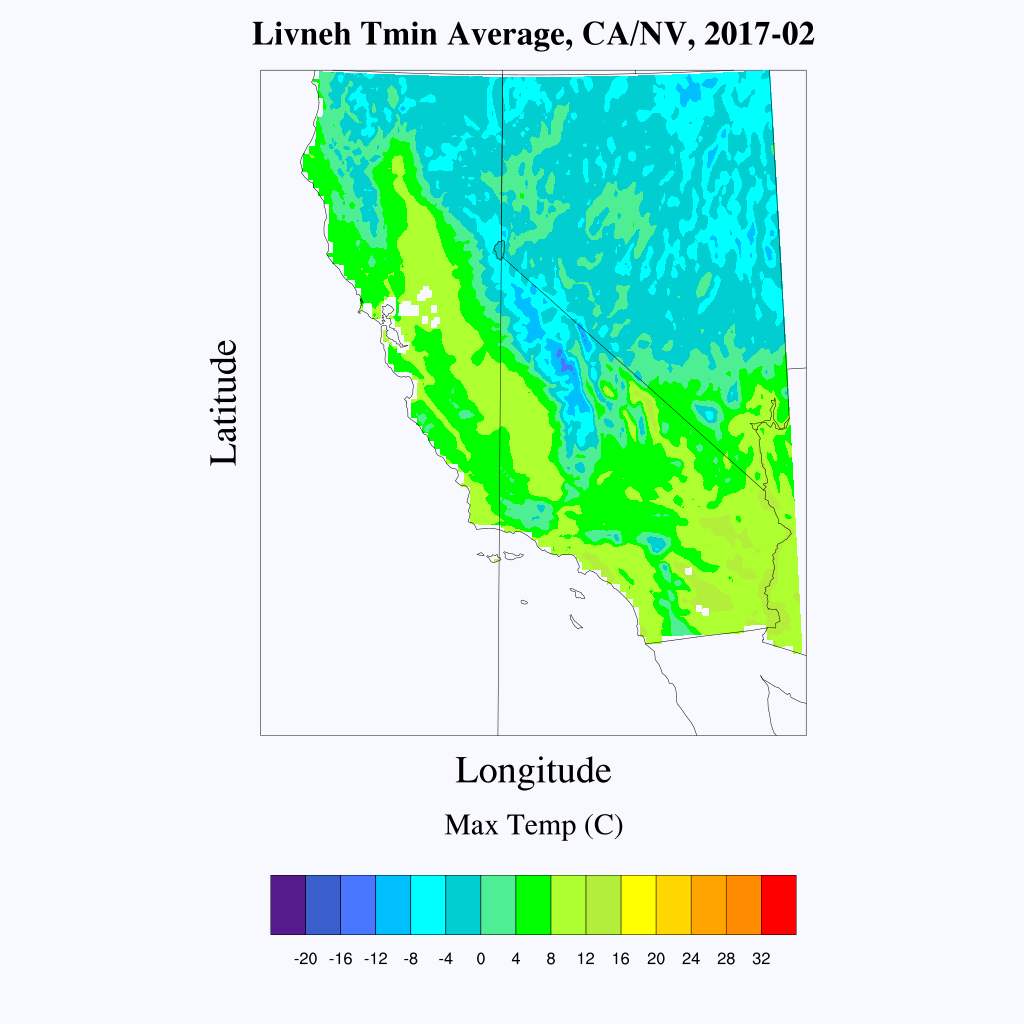

In [14]:
# display plot
display.Image("./17_livneh_avg_ca_nv_tmin.png")